<a href="https://colab.research.google.com/github/SergSof/GAN_train_8_channels_img/blob/main/%D0%A1%D1%82%D1%83%D0%BF%D0%BD%D0%B8_predict_(GAN_pix2pix)%2C_%D0%B2%D1%85%D0%BE%D0%B4_8_(_%D0%B2%D0%BE%D1%81%D0%B5%D0%BC%D1%8C_)_%D0%BA%D0%B0%D0%BD%D0%B0%D0%BB%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PREDICT**
---
**Задача**:  Вернуть смещенную и(или) развернутую ступню в исходное положение, по всем восьми ракурсам.

**Требования**: Линейное расхождение по контуру, между оригинальным и сгенерированным изображением, не более 20 пикселей.

**Dataset**: Изображения ступней, восемь ракурсов (бинарная маска, size 3088 :
2320).

**Инструмент**: GAN pix2pix

**Предобработка**: На вход нейронной сети, подается восьмиканальный массив, shape (N, 2048, 2048, 8), N - samples.
Для подачи массивов, использовался генератор.




In [ ]:
# library

import os
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
# input data

root = '/content/drive/MyDrive/Ступни/8chanel_40sample_new/test_for_predict/cut/output_models_cut_8/'
dir_write_single = '/content/drive/MyDrive/Ступни/8chanel_40sample_new/test_for_predict/cut/img_single/'
dir_write_group = '/content/drive/MyDrive/Ступни/8chanel_40sample_new/test_for_predict/cut/img_group'
NAME = '23655left.pos'
RAKURSES = ['0', '35', '90', '145', '180', '215', '270', '325']
CHANNEL = len(RAKURSES)
dir_model_gan = '/content/drive/MyDrive/Ступни/8chanel_40sample_new/test/model/M____21____.h5' # M_(1...101).h5
g_model = load_model(dir_model_gan)              

In [ ]:
# function

def read_img(dir: str, flag=0) -> np.array:
  img = cv2.imread(dir, 0)[800:2848, 136:2184].astype(np.bool_).astype(np.int8)
  if flag != 25:
    img[img==0] = -1
    img = np.expand_dims(img, axis=2)
  return img #shape np.array (2048, 2048, 1) для flag=25 (2048, 2048)
 

def get_img_25(name: str):
  list_img = list(map(lambda x: read_img(os.path.join(root, f'yaw_{x}', name, '3', '25_segmap.png'), 25), RAKURSES))
  return list_img #list (8,) np.array (2048, 2048)


def get_img_for_predict(name: str):
  list_img = list(map(lambda x: read_img(os.path.join(root, f'yaw_{x}', name, '3', '0_segmap.png')), RAKURSES))
  X1 = np.concatenate(list_img, axis=-1)
  return np.expand_dims(X1, axis=0) #shape np.array (1, 2048, 2048, 8)


def predict_img(img):
  img = g_model.predict(img)[0] * 127.5 + 127.5
  return np.where(img < 128, 0, 255) #shape np.array (2048, 2048, 8)


def get_metrics(im_25, im_gen):
  '''
  Метрики:
  Значения в процентах от общей площади оригинала.
  Первое значение {red} - площадь красной области, лишние сгенерированные пиксели
  Второе значение {green} - площадь зеленой области, не до генерированные пиксели
  '''
  list_metrics = []
  for i in range(CHANNEL):
    _, counts_25 = np.unique(im_25[i], return_counts=True)
    _, counts = np.unique(im_25[i] - im_gen[:,:,i] // 255, return_counts=True)
  
    red = round(counts[0]/counts_25[-1]*100, 1)
    green = round(counts[-1]/counts_25[-1]*100, 1)
    list_metrics.append(f'{red}  ____  {green}')
  return list_metrics # list(8,: str)


def for_visual_img(i: int, row: str) -> np.array:
  if  row == 'Сгенерированные': 
    Z =  np.zeros((3088, 2320, 3))
    img_25_ = np.expand_dims(img_25[i], axis=-1)
    img_gen_ = np.expand_dims(img_gen[:,:,i], axis=-1) // 255
    Z[800:2848, 136:2184] = np.concatenate((img_gen_, img_25_, np.zeros((2048, 2048, 1))), axis=-1)
  else:
    Z =  np.zeros((3088, 2320))
    Z[800:2848, 136:2184] = img_25[i]
  return Z  

In [ ]:
# main

img = get_img_for_predict(NAME)                      #array (1, 2048, 2048, 8)
img_gen = predict_img(img)                           #array (2048, 2048, 8)
img_25 = get_img_25(NAME)                            #list (8, array (2048, 2048))
list_metrics = get_metrics(img_25, img_gen)          #list(8,)

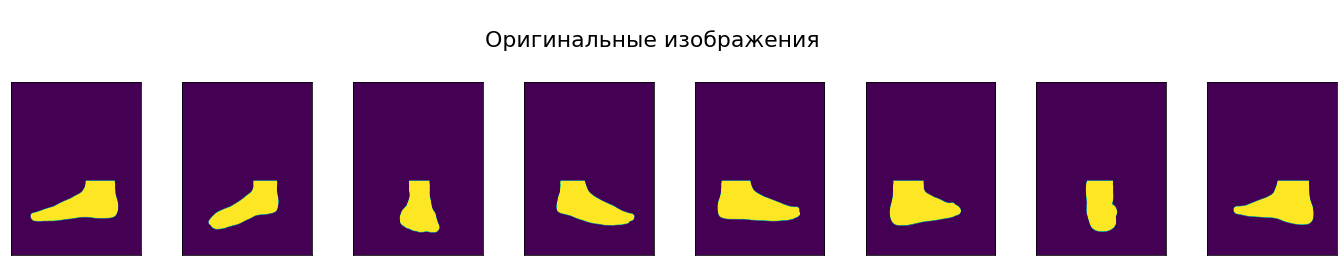

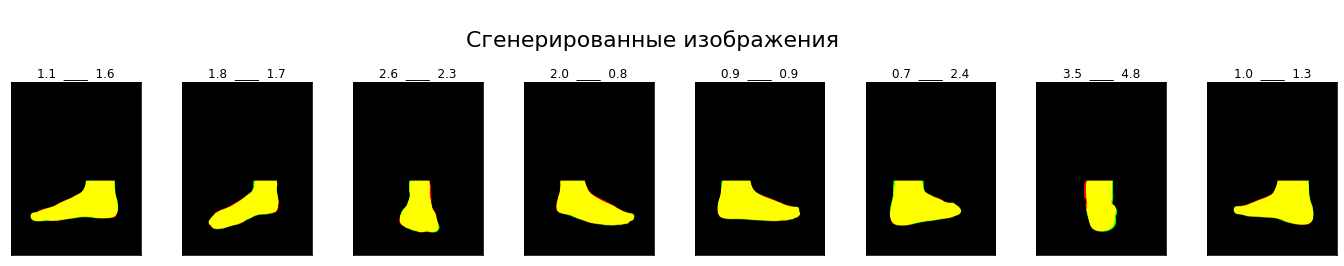

In [ ]:
# visual img 15=9

for j, row in enumerate(('Оригинальные', 'Сгенерированные')):
  fig = plt.figure(figsize=(24, 7))
  fig.suptitle(f'\n{row} изображения', fontsize=22, y=1.03)
  for i in range(CHANNEL):
    ax = fig.add_subplot(2, CHANNEL, 1 + i)
    ax.set(title = list_metrics[i]*j, xticks=[], yticks=[])
    ax.imshow(for_visual_img(i, row))
plt.show()


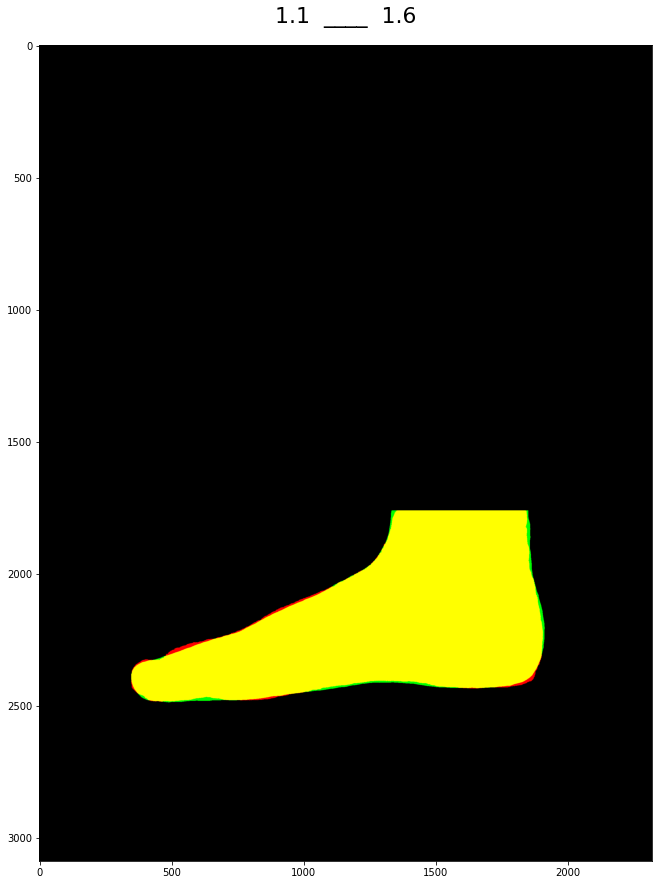

In [ ]:
'''
  Метрики:
  Значения в процентах от общей площади оригинала.
  Первое значение {red} - площадь красной области, лишние сгенерированные пиксели
  Второе значение {green} - площадь зеленой области, не до генерированные пиксели
'''
plt.figure(figsize=(20, 15))
plt.title(list_metrics[0], fontsize=22, y=1.02)
plt.imshow(for_visual_img(0, row='Сгенерированные'))
plt.show()
